In [117]:
"""
Experiment:
Date:
Author:
Goal:
  Compare three identification approaches on SPMe-style synthetic discharge data:
  (1) Discrete-time Model with custom NN state/output maps
  (2) Discrete-time RNN (flax)
  (3) Continuous-time CTModel (diffrax integration)

Metrics:
  - R2 on voltage (train/test)
  - RMSE on voltage (train/test)
  - Training time (wall-clock)

Notes:
  - Data generating system: SPMe-style MOL diffusion + nonlinear voltage algebraic map
  - Input: current I(t)
  - Output: pack voltage V(t)
"""


'\nExperiment:\nDate:\nAuthor:\nGoal:\n  Compare three identification approaches on SPMe-style synthetic discharge data:\n  (1) Discrete-time Model with custom NN state/output maps\n  (2) Discrete-time RNN (flax)\n  (3) Continuous-time CTModel (diffrax integration)\n\nMetrics:\n  - R2 on voltage (train/test)\n  - RMSE on voltage (train/test)\n  - Training time (wall-clock)\n\nNotes:\n  - Data generating system: SPMe-style MOL diffusion + nonlinear voltage algebraic map\n  - Input: current I(t)\n  - Output: pack voltage V(t)\n'

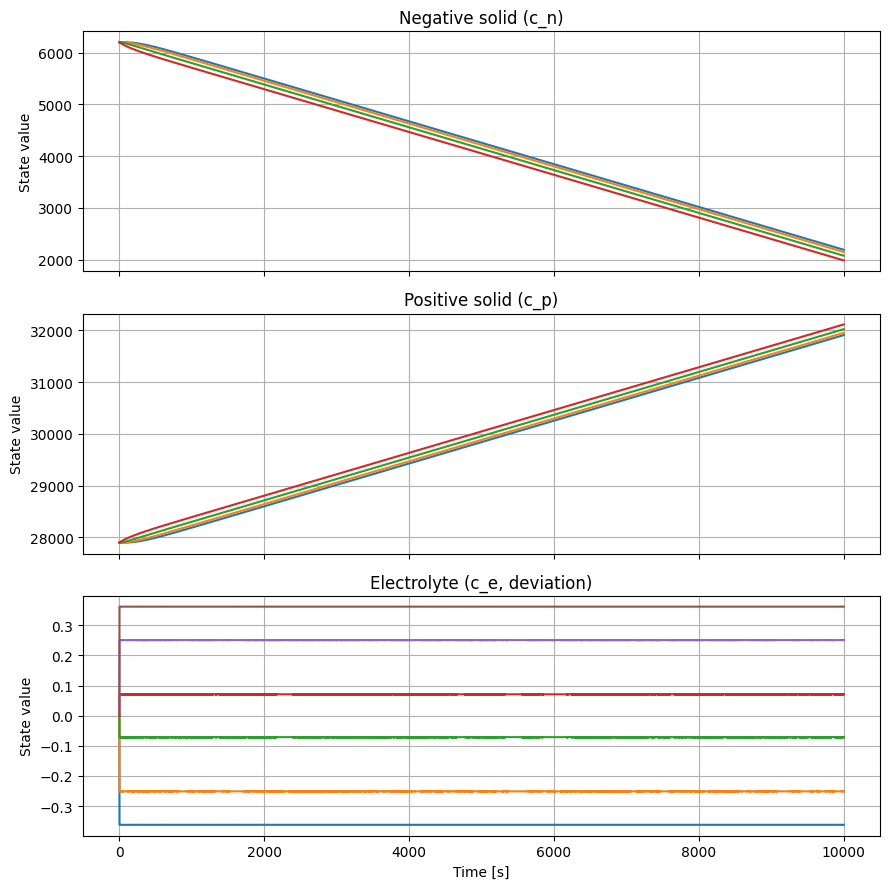

=== State Extrema Summary ===
cn      : min= 1.987e+03, max= 6.200e+03
cp      : min= 2.790e+04, max= 3.211e+04
ce      : min=-3.622e-01, max= 3.622e-01


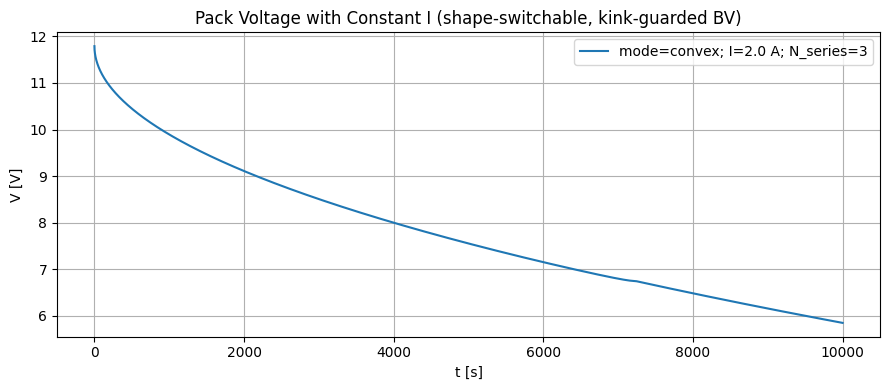

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import jax
import jax.numpy as jnp

from jax_sysid.utils import standard_scale, unscale, compute_scores
from jax_sysid.models import Model, RNN, CTModel

import diffrax

from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import control as ct
from scipy.linalg import block_diag
from IPython.display import display

# =========================================================
# Index map (global)
# =========================================================
# States (SPMe-style reduced MOL):
#   x = [c_n1..c_n4,  c_p1..c_p4,  c_e1..c_e6]
IDX = {
    "cn": slice(0,4),
    "cp": slice(4,8),
    "ce": slice(8,14),

    # "Surface proxy" nodes used in voltage layer
    "cn_surf": 3,   # cn4 -> anode surface
    "cp_surf": 7,   # cp4 -> cathode surface
    "ce_left": 8,   # ce1 (near anode current collector)
    "ce_right": 13, # ce6 (near cathode current collector)
}

# =========================================================
# Unified parameter block
# =========================================================
@dataclass
class Config:
    """
    Parameter set aligned with SPMe + “second-life” degradation paper.
    """
    # Physical constants
    R: float = 8.314462618     # J/(mol·K)
    F: float = 96485.33212     # C/mol
    T: float = 298.15          # K
    T_ref: float = 298.15      # reference temperature for Arrhenius [K]

    # Geometry
    L1: float = 25e-6          # anode thickness [m]
    L2: float = 20e-6          # separator [m]
    L3: float = 25e-6          # cathode [m]
    Rn: float = 5e-6           # anode particle radius [m]
    Rp: float = 5e-6           # cathode particle radius [m]
    A:  float = 1.0            # cell cross-section [m^2]

    # Transport
    Dn: float = 1e-14          # solid diffusivity (anode) [m^2/s]
    Dp: float = 1e-14          # solid diffusivity (cathode) [m^2/s]
    De: float = 7.23e-10       # electrolyte diffusivity [m^2/s]
    eps: float = 0.30          # porosity for electrolyte PDE

    # Effective conductivities for R_el (T.4)
    kappa_n_eff: float = 1.0   # S/m (electrolyte effective in anode region)
    kappa_s_eff: float = 1.0   # S/m (separator)
    kappa_p_eff: float = 1.0   # S/m (cathode)

    # Kinetics / active surface (SPMe)
    a_s_n: float = 1.0e6       # 1/m
    a_s_p: float = 1.0e6       # 1/m
    k_n0: float = 2.0e-11      # base rate constant (anode)
    k_p0: float = 2.0e-11      # base rate constant (cathode)
    use_arrhenius: bool = False
    Ea_n: float = 0.0          # J/mol
    Ea_p: float = 0.0

    # LAM (optional)
    lam_n: float = 0.0
    lam_p: float = 0.0

    # Capacity-scale (stoichiometries)
    csn_max: float = 3.1e4     # mol/m^3
    csp_max: float = 3.1e4     # mol/m^3

    # Electrolyte & electrical
    ce0: float = 1000.0        # mol/m^3
    t_plus: float = 0.38
    k_f: float = 1.0           # scale for Δphi_e term
    R_ohm: float = 0.0         # lumped series resistance (Ω)
    use_dynamic_film: bool = False
    Rf: float = 0.0            # constant fallback [Ω]
    L_sei: float = 0.0         # m
    kappa_sei: float = 1.0     # S/m

    # Modelling flags & sign conventions
    ce_is_deviation: bool = True        # ce states are deviations about ce0
    discharge_positive: bool = True     # I>0 = discharge
    ln_orientation: str = "right_over_left"  # ceR/ceL vs ceL/ceR in log
    eta_mode: str = "diff"              # “diff” -> ηp - ηn (matches T.4)

    # Simulation knobs
    I_dyn: float = 2.0
    I_for_voltage: float = 2.0

    # Pack scaling + time window
    N_series: int = 3
    T_end: float = 5000.0

    # ==============================
    # SHAPE SWITCH (pick at runtime)
    # ==============================
    # "linear"  = straight-line sag (R ramp linear in time)
    # "convex"  = steep early drop then flatten (front-loaded R ramp)
    # "concave" = flat early, steeper later (back-loaded R ramp)
    # "real"    = your previous nonlinear ramp + optional SOC term
    voltage_mode: str = "linear"

    # Endpoints for the time-varying R per *cell* (applies to all modes)
    use_R_ramp: bool = True
    R_ramp_start: float = 0.0          # Ω/cell at t=0
    R_ramp_end: float = 1.0            # Ω/cell at t=T_end

    # Convex preset (front-loaded)
    convex_family: str = "power"       # "power" | "exp"
    convex_power: float = 0.5          # <1 makes it front-loaded
    convex_tau: float = 500.0          # for "exp": small = front-loaded

    # Concave preset (back-loaded)
    concave_family: str = "power"      # "power" | "exp"
    concave_power: float = 3.0         # >1 makes it back-loaded
    concave_tau: float = 3000.0        # for "exp": large = back-loaded

    # "real" mode details (your previous knobs)
    ramp_shape: str = "power"          # "linear" | "power" | "exp"
    ramp_power: float = 3.0
    ramp_tau: float = 1800.0
    use_R_soc: bool = False            # SOC-dependent add-on (realistic)
    R_soc_gain: float = 0.2
    R_soc_alpha: float = 2.0

    # ======= NEW: BV guards (smooth, monotone curves) =======
    theta_guard: float = 1e-3          # keep x in [ε, 1-ε] inside BV only
    I0_floor_p: float = 1e-2           # floor on TOTAL I0_p (Amps)
    I0_floor_n: float = 1e-2           # floor on TOTAL I0_n (Amps)
    bv_scale: float = 0.7              # scale BV overpotentials (1.0 = full)

# =========================================================
# Simple OCVs
# =========================================================
def ocp_p(xp: np.ndarray) -> np.ndarray:
    x = np.clip(xp, 1e-9, 1-1e-9)
    return 4.15 - 0.12*np.tanh((x - 0.60)/0.08)

def ocp_n(xn: np.ndarray) -> np.ndarray:
    x = np.clip(xn, 1e-9, 1-1e-9)
    return 0.10 + 0.80*(1.0/(1.0 + np.exp(-(x-0.50)/0.04)))

# =========================================================
# Solid diffusion blocks (4 nodes)
# =========================================================
def build_An(cfg: Config) -> np.ndarray:
    sn = cfg.Dn/(cfg.Rn**2)
    A = np.zeros((4,4))
    A[0,0], A[0,1] = -24*sn,  24*sn
    A[1,0], A[1,1], A[1,2] =  16*sn, -40*sn, 24*sn
    A[2,1], A[2,2], A[2,3] =  16*sn, -40*sn, 24*sn
    A[3,2], A[3,3] =  16*sn, -16*sn
    return A

def build_Bn(cfg: Config) -> np.ndarray:
    sign = -1.0 if cfg.discharge_positive else +1.0
    b = np.zeros((4,1))
    b[-1,0] = sign * (6.0/cfg.Rn) * (1.0/(cfg.F * cfg.a_s_n * cfg.A * cfg.L1))
    return b

def build_Ap(cfg: Config) -> np.ndarray:
    sp = cfg.Dp/(cfg.Rp**2)
    A = np.zeros((4,4))
    A[0,0], A[0,1] = -24*sp, 24*sp
    A[1,0], A[1,1], A[1,2] = 16*sp, -40*sp, 24*sp
    A[2,1], A[2,2], A[2,3] = 16*sp, -40*sp, 24*sp
    A[3,2], A[3,3] = 16*sp, -16*sp
    return A

def build_Bp(cfg: Config) -> np.ndarray:
    sign = +1.0 if cfg.discharge_positive else -1.0
    b = np.zeros((4,1))
    b[-1,0] = sign * (6.0/cfg.Rp) * (1.0/(cfg.F * cfg.a_s_p * cfg.A * cfg.L3))
    return b

# =========================================================
# Electrolyte diffusion block (1-D MOL)
# =========================================================
def build_Ae(cfg: Config) -> np.ndarray:
    K = cfg.De/cfg.eps
    Ae = np.zeros((6,6))
    w_in   = lambda L: K * 4.0 / (L**2)
    w_intf = lambda La, Lb: K * 16.0 / ((La + Lb)**2)
    w11 = w_in(cfg.L1); w12 = w_intf(cfg.L1, cfg.L2)
    w23 = w_in(cfg.L2); w34 = w_intf(cfg.L2, cfg.L3); w45 = w_in(cfg.L3)
    Ae[0,0] = -(w11);                 Ae[0,1] = +(w11)
    Ae[1,0] = +(w11); Ae[1,1] = -(w11 + w12); Ae[1,2] = +(w12)
    Ae[2,1] = +(w12); Ae[2,2] = -(w12 + w23); Ae[2,3] = +(w23)
    Ae[3,2] = +(w23); Ae[3,3] = -(w23 + w34); Ae[3,4] = +(w34)
    Ae[4,3] = +(w34); Ae[4,4] = -(w34 + w45); Ae[4,5] = +(w45)
    Ae[5,4] = +(w45); Ae[5,5] = -(w45)
    return Ae

def build_Be(cfg: Config) -> np.ndarray:
    b = np.zeros((6,1))
    sign_left  = -1.0 if cfg.discharge_positive else +1.0
    sign_right = +1.0 if cfg.discharge_positive else -1.0
    s1 = sign_left  * (1.0 - cfg.t_plus) / (cfg.F * cfg.A * cfg.L1 * cfg.eps)
    s3 = sign_right * (1.0 - cfg.t_plus) / (cfg.F * cfg.A * cfg.L3 * cfg.eps)
    b[0,0] = s1; b[1,0] = s1
    b[4,0] = s3; b[5,0] = s3
    return b

# =========================================================
# Assembly
# =========================================================
def assemble_system(cfg: Config):
    An = build_An(cfg);   Ap = build_Ap(cfg);   Ae = build_Ae(cfg)
    Bn = build_Bn(cfg);   Bp = build_Bp(cfg);   Be = build_Be(cfg)
    Aglob = block_diag(An, Ap, Ae)
    Bglob = np.vstack([Bn, Bp, Be])
    state_names = [f'cn{i}' for i in range(1,5)] + \
                  [f'cp{i}' for i in range(1,5)] + \
                  [f'ce{i}' for i in range(1,7)]
    S = ct.ss(Aglob, Bglob, np.eye(Aglob.shape[0]), np.zeros((Aglob.shape[0],1)))
    return S, Aglob, Bglob, (An, Ap, Ae, Bn, Bp, Be), state_names

# =========================================================
# Helpers (ICs, tables, plots)
# =========================================================
def make_x0(cfg: Config, theta_n0=0.2, theta_p0=0.9, ce0=0.0):
    x0 = np.zeros(14)
    x0[IDX["cn"]] = theta_n0 * cfg.csn_max
    x0[IDX["cp"]] = theta_p0 * cfg.csp_max
    x0[IDX["ce"]] = ce0
    return x0

def show_matrices(An, Ap, Ae, Bn, Bp, Be, A, B, state_names):
    def df(M, rnames, cnames): return pd.DataFrame(M, index=rnames, columns=cnames)
    cn_names = [f'cn{i}' for i in range(1, An.shape[0]+1)]
    cp_names = [f'cp{i}' for i in range(1, Ap.shape[0]+1)]
    ce_names = [f'ce{i}' for i in range(1, Ae.shape[0]+1)]
    display(df(An, cn_names, cn_names)); display(df(Bn, cn_names, ['u']))
    display(df(Ap, cp_names, cp_names)); display(df(Bp, cp_names, ['u']))
    display(df(Ae, ce_names, ce_names)); display(df(Be, ce_names, ['u']))
    display(df(A, state_names, state_names)); display(df(B, state_names, ['u']))
    print("A shape:", A.shape, " B shape:", B.shape)

def plot_states_grouped(t: np.ndarray, X_TN: np.ndarray):
    fig, axs = plt.subplots(3, 1, figsize=(9, 9), sharex=True)
    axs[0].plot(t, X_TN[:, IDX["cn"]]); axs[0].set_title("Negative solid (c_n)")
    axs[1].plot(t, X_TN[:, IDX["cp"]]); axs[1].set_title("Positive solid (c_p)")
    axs[2].plot(t, X_TN[:, IDX["ce"]]); axs[2].set_title("Electrolyte (c_e, deviation)")
    for ax in axs: ax.grid(True); ax.set_ylabel("State value")
    axs[-1].set_xlabel("Time [s]"); plt.tight_layout(); plt.show()

def report_extrema_matrix(X_TN: np.ndarray):
    print("=== State Extrema Summary ===")
    for name in ["cn","cp","ce"]:
        arr = X_TN[:, IDX[name]]
        print(f"{name:<8s}: min={arr.min(): .3e}, max={arr.max(): .3e}")

# =========================================================
# Kinetics & voltage
# =========================================================
def _arrhenius(k0: float, Ea: float, cfg: Config) -> float:
    if not cfg.use_arrhenius or Ea == 0.0: return k0
    return k0 * np.exp(-Ea/cfg.R * (1.0/cfg.T - 1.0/cfg.T_ref))

def i0_current_scales(xp: float, xn: float, ceL: float, ceR: float, cfg: Config) -> tuple[float, float]:
    """
    Return TOTAL exchange currents (Amps) with guards:
      - stoichiometry soft-guard (theta_guard)
      - minimum floors on I0 totals (I0_floor_p/n)
    """
    ce_avg = 0.5 * (ceL + ceR)
    ce_avg = float(np.clip(ce_avg, 1e-12, 10.0 * cfg.ce0))

    # Soft-guard the BV singularity ONLY in BV (not in OCV)
    xp_eff = float(np.clip(xp, cfg.theta_guard, 1.0 - cfg.theta_guard))
    xn_eff = float(np.clip(xn, cfg.theta_guard, 1.0 - cfg.theta_guard))

    Sp = (1.0 - cfg.lam_p) * cfg.a_s_p * cfg.A * cfg.L3
    Sn = (1.0 - cfg.lam_n) * cfg.a_s_n * cfg.A * cfg.L1
    kp = _arrhenius(cfg.k_p0, cfg.Ea_p, cfg)
    kn = _arrhenius(cfg.k_n0, cfg.Ea_n, cfg)

    i0p = cfg.F * kp * cfg.csp_max * np.sqrt(ce_avg) * np.sqrt(xp_eff * (1.0 - xp_eff))
    i0n = cfg.F * kn * cfg.csn_max * np.sqrt(ce_avg) * np.sqrt(xn_eff * (1.0 - xn_eff))

    I0p_tot = max(float(Sp * i0p), cfg.I0_floor_p)
    I0n_tot = max(float(Sn * i0n), cfg.I0_floor_n)
    return I0p_tot, I0n_tot

def electrolyte_log_term(ceL: float, ceR: float, cfg: Config) -> float:
    ceL = max(ceL, 1e-12); ceR = max(ceR, 1e-12)
    ln_arg = (ceR/ceL) if cfg.ln_orientation == "right_over_left" else (ceL/ceR)
    return (2.0*cfg.R*cfg.T/cfg.F) * (1.0 - cfg.t_plus) * cfg.k_f * np.log(ln_arg)

def electrolyte_resistance(cfg: Config) -> float:
    return (cfg.L1/cfg.kappa_n_eff + 2.0*cfg.L2/cfg.kappa_s_eff + cfg.L3/cfg.kappa_p_eff) / (2.0*cfg.A)

def film_resistance(cfg: Config) -> float:
    if cfg.use_dynamic_film and cfg.L_sei > 0.0:
        return cfg.L_sei / (cfg.kappa_sei * cfg.a_s_n * cfg.A * cfg.L1)
    return cfg.Rf

# --- Mode-aware series resistance pieces ---
def _ramp_fraction(cfg: Config, t: float) -> float:
    """Return a 0..1 fraction for the time-varying R ramp based on shape mode."""
    s = max(0.0, min(t, cfg.T_end)) / max(1e-12, cfg.T_end)

    mode = cfg.voltage_mode.lower()
    if mode == "linear":
        return s

    if mode == "convex":
        if cfg.convex_family == "power":
            p = max(1e-6, min(cfg.convex_power, 1.0))  # keep <1
            return s**p
        else:  # "exp"
            frac = 1.0 - np.exp(- t / max(1e-9, cfg.convex_tau))
            return min(frac, 1.0)

    if mode == "concave":
        if cfg.concave_family == "power":
            p = max(1.0, cfg.concave_power)           # keep >1
            return s**p
        else:  # "exp"
            frac = 1.0 - np.exp(- t / max(1e-9, cfg.concave_tau))
            return min(frac, 1.0)

    # "real" (your previous behavior)
    shape = cfg.ramp_shape
    if shape == "power":
        return s**cfg.ramp_power
    if shape == "exp":
        frac = 1.0 - np.exp(- t / max(1e-9, cfg.ramp_tau))
        return min(frac, 1.0)
    return s

def _R_soc_extra(xp: float, xn: float, cfg: Config) -> float:
    # Only apply the SOC term in "real" mode (to keep convex/concave presets pure)
    if cfg.voltage_mode.lower() != "real" or not cfg.use_R_soc:
        return 0.0
    soc = 0.5*(xp + (1.0 - xn))  # 1 at full, 0 at empty
    return cfg.R_soc_gain * (1.0 - soc)**cfg.R_soc_alpha

def effective_R_cell(cfg: Config, t: float, xp: float, xn: float) -> float:
    """Total per-cell series resistance including base + ramp (+ SOC if 'real')."""
    R_base = cfg.R_ohm + electrolyte_resistance(cfg) + film_resistance(cfg)
    if cfg.use_R_ramp:
        frac = _ramp_fraction(cfg, t)
        R_base += cfg.R_ramp_start + (cfg.R_ramp_end - cfg.R_ramp_start) * frac
    return R_base + _R_soc_extra(xp, xn, cfg)

def terminal_voltage(x: np.ndarray, cfg: Config, I: float | None = None,
                     t: float | None = None, return_terms: bool = False):
    """
    V_pack = N_series * [ (Up - Un) + (ηp - ηn) + Δφ_e - I * R_cell_eff(t, SOC) ]
    """
    I_use = cfg.I_for_voltage if (I is None) else float(I)
    xp = np.clip(x[IDX["cp_surf"]] / cfg.csp_max, 1e-9, 1-1e-9)
    xn = np.clip(x[IDX["cn_surf"]] / cfg.csn_max, 1e-9, 1-1e-9)
    Up = float(ocp_p(np.array([xp]))[0]); Un = float(ocp_n(np.array([xn]))[0])
    ceL_raw = float(x[IDX["ce_left"]]);  ceR_raw = float(x[IDX["ce_right"]])
    ceL = (cfg.ce0 + ceL_raw) if cfg.ce_is_deviation else ceL_raw
    ceR = (cfg.ce0 + ceR_raw) if cfg.ce_is_deviation else ceR_raw

    I0p_tot, I0n_tot = i0_current_scales(xp, xn, ceL, ceR, cfg)

    # BV overpotentials with floors + optional damping
    coeff = (2.0*cfg.R*cfg.T/cfg.F)
    eta_p = coeff * np.arcsinh(I_use / (2.0*I0p_tot))
    eta_n = coeff * np.arcsinh(I_use / (2.0*I0n_tot))
    if cfg.bv_scale != 1.0:
        eta_p *= cfg.bv_scale
        eta_n *= cfg.bv_scale
    eta_combo = (eta_p - eta_n) if (cfg.eta_mode == "diff") else (eta_p + eta_n)

    dphi_e = electrolyte_log_term(ceL, ceR, cfg)
    R_cell = effective_R_cell(cfg, 0.0 if t is None else float(t), float(xp), float(xn))

    V_cell = (Up - Un) + eta_combo + dphi_e - I_use * R_cell
    V_pack = cfg.N_series * V_cell

    if not return_terms:
        return float(V_pack)
    return float(V_pack), {"Up":Up,"Un":Un,"eta_p":float(eta_p),"eta_n":float(eta_n),
                           "dphi_e":float(dphi_e),"R_cell":float(R_cell),
                           "I":float(I_use),"mode":cfg.voltage_mode,
                           "I0p_tot":float(I0p_tot),"I0n_tot":float(I0n_tot)}

# =========================================================
# Nonlinear IOSystem (A,B driven by I_dyn; output uses same I)
# =========================================================
def battery_update(t, x, u, params):
    A = params["A"]; B = params["B"]; cfg = params["cfg"]
    return (A @ x + B[:, 0] * cfg.I_dyn)

def battery_output(t, x, u, params):
    cfg = params["cfg"]
    V, _ = terminal_voltage(x, cfg, I=cfg.I_dyn, t=t, return_terms=True)
    return np.hstack([x, V])

# =========================================================
# Example (tweak CFG below)
# =========================================================
if __name__ == "__main__":
    # --- parameters ---
    CFG = Config()  # defaults set above

    # --- simulation grid (10,000 s) ---
    SIM_T_END = 10_000.0     # seconds
    # SIM_DT    = 0.005        # ~2,000,001 samples
    SIM_DT = 0.1         # ~100,001 samples
    T = np.arange(0.0, SIM_T_END + SIM_DT, SIM_DT)
    CFG.T_end = float(T[-1])

    # 🔀 Pick your shape here:
    # CFG.voltage_mode = "linear"
    CFG.voltage_mode = "convex"
    # CFG.voltage_mode = "concave"
    # CFG.voltage_mode = "real"

    # ---- Smooth, monotone curve guards ----
    CFG.theta_guard = 1e-3
    CFG.I0_floor_p  = 1e-2   # Amps (total)
    CFG.I0_floor_n  = 1e-2   # Amps (total)
    CFG.bv_scale    = 0.7    # soften BV a bit for extra smoothness

    # --- assemble system ---
    S, A, B, (An, Ap, Ae, Bn, Bp, Be), state_names = assemble_system(CFG)

    # --- pack params for nlsys ---
    nl_params = dict(A=A, B=B, cfg=CFG)

    # --- create nonlinear IOSystem (no exogenous input) ---
    battery_nl = ct.nlsys(
        battery_update, battery_output,
        name="battery_unified_cfg", params=nl_params,
        states=state_names,                      # 14 states
        outputs=state_names + ["V_full_constI"], # states + V(I=const)
        inputs=0
    )

    # --- initial state ---
    x0 = make_x0(CFG, theta_n0=0.2, theta_p0=0.9, ce0=0.0)
    # x0 = make_x0(CFG, theta_n0=15, theta_p0=0.01, ce0=15)

    # --- simulate ---
    resp = ct.input_output_response(battery_nl, T, 0, X0=x0)
    t = resp.time
    X = resp.states
    Y = resp.outputs
    Vout = Y[-1, :]

    # --- quick plots ---
    plot_states_grouped(t, X.T)
    report_extrema_matrix(X.T)

    plt.figure(figsize=(9,4))
    plt.plot(t, Vout, label=f"mode={CFG.voltage_mode}; I={CFG.I_for_voltage} A; N_series={CFG.N_series}")
    plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
    plt.title("Pack Voltage with Constant I (shape-switchable, kink-guarded BV)")
    plt.legend(); plt.tight_layout(); plt.show()


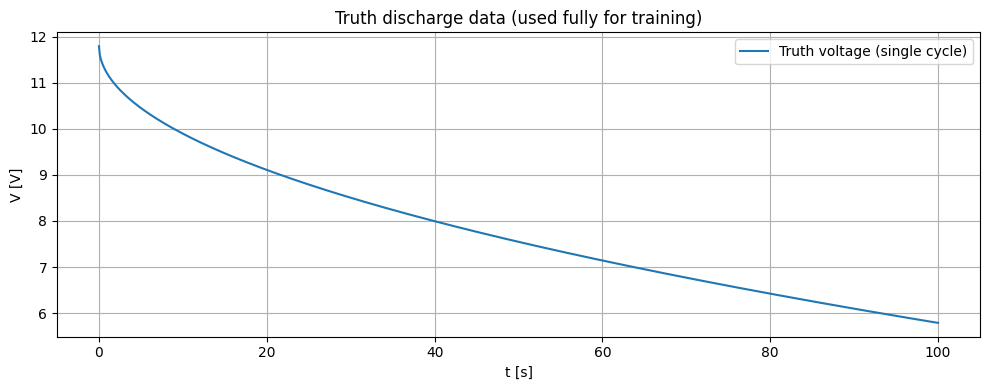

Shapes: t (1001,) U (1001, 1) Y (1001, 1)


In [ ]:
# import numpy as np
# import control as ct

def generate_discharge_data(
    cfg: Config,
    I_const: float = 2.0,
    U_profile: np.ndarray | None = None,   # optional (N,1) profile (ignored if inputs=0)
    sim_t_end: float = 10_000.0,
    sim_dt: float = 0.1,
    theta_n0: float = 0.2,
    theta_p0: float = 0.9,
    ce0: float = 0.0,
):
    """
    Generate one continuous-time discharge trajectory with constant current.
    Returns:
        T: (N,) time vector
        U: (N,1) input current profile (constant, for jax-sysid)
        X: (N,14) state trajectory
        Y: (N,1) measured output = pack voltage
        Y_full: (N,15) optional = [states, voltage] if you want it
    """
    # time grid
    T = np.arange(0.0, sim_t_end + sim_dt, sim_dt)
    cfg.T_end = float(T[-1])

    # enforce constant current (generator uses cfg.I_dyn for state update & same I for voltage)
    cfg.I_dyn = float(I_const)
    cfg.I_for_voltage = float(I_const)

    # assemble model
    _, A, B, _, state_names = assemble_system(cfg)
    nl_params = dict(A=A, B=B, cfg=cfg)

    # build nonlinear IOSystem (no external input; current is embedded through cfg.I_dyn)
    battery_nl = ct.nlsys(
        battery_update,
        battery_output,
        name="battery_unified_cfg",
        params=nl_params,
        states=state_names,                     
        outputs=state_names + ["V_full_constI"], 
        inputs=0,
    )

    # initial state
    x0 = make_x0(cfg, theta_n0=theta_n0, theta_p0=theta_p0, ce0=ce0)

    # simulate
    resp = ct.input_output_response(battery_nl, T, 0, X0=x0)
    X = resp.states.T            # (N,14)
    Y_full = resp.outputs.T      # (N,15)
    V = Y_full[:, -1:]           # (N,1)

    # Build U for jax-sysid (even though generator had inputs=0)
    # This is what you'll pass as Us into CTModel.fit(Y, U, T)
    U = np.full((len(T), 1), float(I_const))

    return T, U, X, V, Y_full



# -------------------------------
# Stage 1 — Generate one discharge cycle (truth data)
# -------------------------------
CFG = Config()
CFG.theta_guard = 1e-3
CFG.I0_floor_p  = 1e-2
CFG.I0_floor_n  = 1e-2
CFG.bv_scale    = 0.7
CFG.voltage_mode = "convex"   # choose: linear/convex/concave/real

t, U, X, Y, Y_full = generate_discharge_data(CFG, I_const=2.0, sim_t_end=100.0, sim_dt=0.1)

plt.figure(figsize=(10,4))
plt.plot(t, Y, label="Truth voltage (single cycle)")
plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("Truth discharge data (used fully for training)")
plt.legend(); plt.tight_layout(); plt.show()

print("Shapes:", "t", t.shape, "U", U.shape, "Y", Y.shape)



In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
import diffrax
from jax_sysid.models import CTModel
from jax_sysid.utils import standard_scale, unscale

# -----------------------
# 0) Data sanity helpers
# -----------------------
def ensure_N1(a, name, N):
    a = np.asarray(a)
    if a.ndim == 1:
        a = a.reshape(-1, 1)
    if a.shape[0] != N and a.shape[1] == N:
        a = a.T
    assert a.shape[0] == N, f"{name}.shape {a.shape} must have first dim = {N}"
    return a

# -----------------------
# 1) Stable parameter map
# -----------------------
def theta_map(raw_theta: jnp.ndarray) -> jnp.ndarray:
    th = raw_theta

    th = th.at[0:7].set(jnp.exp(raw_theta[0:7]))      # diffusion scales
    th = th.at[7:11].set(jnp.exp(raw_theta[7:11]))    # input gains

    th = th.at[19].set(jnp.exp(raw_theta[19]))        # th20
    th = th.at[20].set(jnp.exp(raw_theta[20]))        # th21
    th = th.at[22].set(jnp.exp(raw_theta[22]))        # th23
    th = th.at[23].set(jnp.exp(raw_theta[23]))        # th24

    th = th.at[24].set(jnp.exp(raw_theta[24]))        # th25 (NEW ramp amplitude)

    return th



# -----------------------
# 2) Your A,B builder (unchanged)
# -----------------------
def build_A_B_from_theta(theta):
    th1, th2, th3, th4, th5, th6, th7, th8, th9, th10, th11 = theta[:11]

    A = jnp.zeros((14, 14))

    An = th1 * jnp.array([
        [-24.,  24.,   0.,   0.],
        [ 16., -40.,  24.,   0.],
        [  0.,  16., -40.,  24.],
        [  0.,   0.,  16., -16.],
    ])
    A = A.at[0:4, 0:4].set(An)

    Ap = th2 * jnp.array([
        [-24.,  24.,   0.,   0.],
        [ 16., -40.,  24.,   0.],
        [  0.,  16., -40.,  24.],
        [  0.,   0.,  16., -16.],
    ])
    A = A.at[4:8, 4:8].set(Ap)

    Ae = jnp.array([
        [-4*th3,          4*th3,              0.,               0.,               0.,          0.],
        [ 4*th3, -(4*th3 + 16*th4),        16*th4,              0.,               0.,          0.],
        [ 0.,         16*th4, -(16*th4 + 4*th5),          4*th5,               0.,          0.],
        [ 0.,              0.,          4*th5, -(4*th5 + 16*th6),        16*th6,          0.],
        [ 0.,              0.,              0.,         16*th6, -(16*th6 + 4*th7),       4*th7],
        [ 0.,              0.,              0.,              0.,          4*th7,     -4*th7],
    ])
    A = A.at[8:14, 8:14].set(Ae)

    B = jnp.zeros((14, 1))
    B = B.at[3, 0].set(6.0 * th8)
    B = B.at[7, 0].set(6.0 * th9)
    B = B.at[8, 0].set(th10)
    B = B.at[9, 0].set(th10)
    B = B.at[12, 0].set(th11)
    B = B.at[13, 0].set(th11)
    return A, B

# -----------------------
# 3) Voltage (add strong guards)
# -----------------------
def voltage_activation_from_theta(x, I, t, theta, ce0=1000.0, ce_is_deviation=True, N_series=3, T_end=100.0):
    # unpack: now th25 exists
    th12, th13, th14, th15, th16, th17, th18, th19, th20, th21, th22, th23, th24, th25 = theta[11:25]

    # ... (your xp/xn/ce guards unchanged)

    Up = th12 + th13 * jnp.tanh((xp - th14) / (th15 + 1e-6))
    Un = th16 + th17 * (1.0 / (1.0 + jnp.exp(-(xn - th18) / (th19 + 1e-6))))

    denom_p = th20 * jnp.sqrt(ce_avg) * jnp.sqrt(xp * (1.0 - xp)) + 1e-6
    denom_n = th21 * jnp.sqrt(ce_avg) * jnp.sqrt(xn * (1.0 - xn)) + 1e-6
    VBV = th24 * (jnp.arcsinh(I / denom_p) - jnp.arcsinh(I / denom_n))

    Ve = th22 * jnp.log(ceR / ceL)

    # NEW: time-normalized ramp (0..1)
    tnorm = jnp.clip(t / (T_end + 1e-9), 0.0, 1.0)

    # NEW: ohmic with ramp
    Vohm = -I * (th23 + th25 * tnorm)

    V_cell = (Up - Un) + VBV + Ve + Vohm
    V_pack = N_series * V_cell
    return jnp.nan_to_num(V_pack, nan=0.0, posinf=0.0, neginf=0.0)


# -----------------------
# 4) State/output fns (IMPORTANT: apply theta_map!)
# -----------------------
@jax.jit
def state_fcn(x, u, t, params):
    (raw_theta,) = params
    theta = theta_map(raw_theta)
    A, B = build_A_B_from_theta(theta)
    I = u[0]
    return A @ x + (B[:, 0] * I)

T_end_ident = float(t[-1])  # after you build numpy t

@jax.jit
def output_fcn(x, u, t, params):
    (raw_theta,) = params
    theta = theta_map(raw_theta)
    I = u[0]
    Vpack = voltage_activation_from_theta(
        x, I, t, theta,
        ce0=1000.0, ce_is_deviation=True,
        N_series=3, T_end=T_end_ident
    )
    return jnp.array([Vpack])


# -----------------------
# 5) Prepare data (optionally scale for conditioning)
# -----------------------
t = np.asarray(t).reshape(-1)
N = t.shape[0]
U = ensure_N1(U, "U", N).astype(np.float32)
Y = ensure_N1(Y, "Y", N).astype(np.float32)

# Scaling helps Adam a LOT (recommended)
Ys, ymean, ygain = standard_scale(Y)
Us = U

# -----------------------
# 6) Build & train CTModel
# -----------------------
nx, ny, nu = 14, 1, 1
model = CTModel(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)

# IMPORTANT: raw_theta is unconstrained; theta_map makes it stable.
theta0_raw = np.zeros(25, dtype=np.float32) # was 24

# diffusion-like scalars th1..th7: want magnitude ~1e-3 ... 1e-4, not 1.0
theta0_raw[0:7] = np.log(1e-3).astype(np.float32)

# input gains th8..th11: start small to avoid blasting states
theta0_raw[7:11] = np.log(1e-7).astype(np.float32)

# BV denom scales th20/th21: start ~1
theta0_raw[19] = np.log(1.0).astype(np.float32)
theta0_raw[20] = np.log(1.0).astype(np.float32)

# Ohmic th23: start around 0.05 (tune)
theta0_raw[22] = np.log(5e-2).astype(np.float32)

# BV scale th24: start ~1
theta0_raw[23] = np.log(1.0).astype(np.float32)

model.init(params=[theta0_raw], x0=np.array(X[0], dtype=np.float32))

th_init = np.array(theta_map(jnp.array(theta0_raw)))
A0, B0 = build_A_B_from_theta(jnp.array(th_init))
eigA0 = np.linalg.eigvals(np.array(A0))
print("max Re(eig(A0)) =", np.max(np.real(eigA0)))
print("min Re(eig(A0)) =", np.min(np.real(eigA0)))


# model.loss(rho_x0=0.0, rho_th=1e-5)
model.loss(rho_x0=1e-2, rho_th=1e-3)   # give x0 some penalty so it doesn’t slam saturation

# model.optimization(adam_epochs=300, lbfgs_epochs=400, adam_eta=2e-3)
model.optimization(adam_epochs=500, lbfgs_epochs=0, adam_eta=2e-3)

# Use a solver that is more forgiving when things get stiff
# KenCarp is a good default for semi-stiff problems
model.integration_options(
    ode_solver=diffrax.Tsit5(),
    dt0=(t[1] - t[0])/ 10.0,                 # start at your sample dt
    max_steps=3_000_000,
    # stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-5,),
    stepsize_controller=diffrax.PIDController(rtol=1e-2, atol=1e-4),
)

# quick pre-fit prediction (scaled)
Yshat0, Xhat0 = model.predict(model.x0, Us, t)

# fit (scaled)
model.fit(Ys, Us, t)

# final prediction (scaled -> unscale)
Yshat, Xhat = model.predict(model.x0, Us, t)
Yhat = unscale(Yshat, ymean, ygain)


max Re(eig(A0)) = -1.5930962223275692e-18
min Re(eig(A0)) = -0.06771280825447913


  0%|                        |

Solving NLP with Adam (38 optimization variables) ...


  1%|▏                       |
    f =  32673995.540564, f* =  32673995.540564, |grad f| =  1143.502958, iter = 2
100%|████████████████████████|
    f =  32671279.717318, f* =  32671279.717318, |grad f| =  1143.244206, iter = 500


You may have to increase the values of 'xsat' or 'rho_x0'


In [122]:
# import jax
# import jax.numpy as jnp

# def build_A_B_from_theta(theta):
#     """
#     theta: (24,) or (11,) at least.
#     Returns:
#       A: (14,14)
#       B: (14,1)
#     """
#     # --- unpack ---
#     th1, th2, th3, th4, th5, th6, th7, th8, th9, th10, th11 = theta[:11]

#     A = jnp.zeros((14, 14))

#     # --- An block (cn1..cn4) uses th1 with the same stencil as your build_An ---
#     # rows/cols 0..3
#     # [-24  24   0   0
#     #   16 -40  24   0
#     #    0  16 -40  24
#     #    0   0  16 -16] * th1
#     An = th1 * jnp.array([
#         [-24.,  24.,   0.,   0.],
#         [ 16., -40.,  24.,   0.],
#         [  0.,  16., -40.,  24.],
#         [  0.,   0.,  16., -16.],
#     ])
#     A = A.at[0:4, 0:4].set(An)

#     # --- Ap block (cp1..cp4) uses th2 ---
#     Ap = th2 * jnp.array([
#         [-24.,  24.,   0.,   0.],
#         [ 16., -40.,  24.,   0.],
#         [  0.,  16., -40.,  24.],
#         [  0.,   0.,  16., -16.],
#     ])
#     A = A.at[4:8, 4:8].set(Ap)

#     # --- Ae block (ce1..ce6) uses th3..th7 (documented structure) ---
#     # This is the same banded pattern shown in the PDF for ce-states. :contentReference[oaicite:6]{index=6}
#     Ae = jnp.array([
#         [-4*th3,          4*th3,              0.,               0.,               0.,          0.],
#         [ 4*th3, -(4*th3 + 16*th4),        16*th4,              0.,               0.,          0.],
#         [ 0.,         16*th4, -(16*th4 + 4*th5),          4*th5,               0.,          0.],
#         [ 0.,              0.,          4*th5, -(4*th5 + 16*th6),        16*th6,          0.],
#         [ 0.,              0.,              0.,         16*th6, -(16*th6 + 4*th7),       4*th7],
#         [ 0.,              0.,              0.,              0.,          4*th7,     -4*th7],
#     ])
#     A = A.at[8:14, 8:14].set(Ae)

#     # --- B structure (14x1) as in PDF (cn4, cp4, ce1/ce2, ce5/ce6) ---
#     # B[3] = 6*th8, B[7]=6*th9, B[8]=th10, B[9]=th10, B[12]=th11, B[13]=th11 :contentReference[oaicite:7]{index=7}
#     B = jnp.zeros((14, 1))
#     B = B.at[3, 0].set(6.0 * th8)
#     B = B.at[7, 0].set(6.0 * th9)
#     B = B.at[8, 0].set(th10)
#     B = B.at[9, 0].set(th10)
#     B = B.at[12, 0].set(th11)
#     B = B.at[13, 0].set(th11)

#     return A, B


In [123]:
# def voltage_activation_from_theta(x, I, theta, ce0=1000.0, ce_is_deviation=True, N_series=3):
#     """
#     x: (14,)
#     I: scalar (current)
#     theta: (24,)
#     returns: scalar pack voltage
#     """
#     # θ12..θ24
#     th12, th13, th14, th15, th16, th17, th18, th19, th20, th21, th22, th23, th24 = theta[11:24]

#     # surface proxies / side electrolyte nodes (same mapping as your generator)
#     xp = jnp.clip(x[7] / 3.1e4, 1e-9, 1.0 - 1e-9)   # cp4/csp_max (csp_max here is your default)
#     xn = jnp.clip(x[3] / 3.1e4, 1e-9, 1.0 - 1e-9)   # cn4/csn_max

#     ceL_raw = x[8]
#     ceR_raw = x[13]
#     ceL = (ce0 + ceL_raw) if ce_is_deviation else ceL_raw
#     ceR = (ce0 + ceR_raw) if ce_is_deviation else ceR_raw
#     ce_avg = jnp.clip(0.5 * (ceL + ceR), 1e-12, 1e12)

#     # OCV surrogates (lumped)
#     Up = th12 + th13 * jnp.tanh((xp - th14) / (th15 + 1e-12))
#     Un = th16 + th17 * (1.0 / (1.0 + jnp.exp(-(xn - th18) / (th19 + 1e-12))))

#     # Butler–Volmer combo (as written in the PDF, with θ24 scaling)
#     # VBV = θ24 * [ asinh( I/(θ20*sqrt(ce_avg)*sqrt(xp(1-xp))) ) - asinh( I/(θ21*sqrt(ce_avg)*sqrt(xn(1-xn))) ) ]
#     denom_p = th20 * jnp.sqrt(ce_avg) * jnp.sqrt(xp * (1.0 - xp)) + 1e-12
#     denom_n = th21 * jnp.sqrt(ce_avg) * jnp.sqrt(xn * (1.0 - xn)) + 1e-12
#     VBV = th24 * (jnp.arcsinh(I / denom_p) - jnp.arcsinh(I / denom_n))

#     # electrolyte log term
#     Ve = th22 * jnp.log((ceR + 1e-12) / (ceL + 1e-12))

#     # ohmic lump
#     Vohm = -I * th23

#     V_cell = (Up - Un) + VBV + Ve + Vohm
#     return N_series * V_cell


In [124]:
# def theta_map(raw_theta):
#     # force diffusion-like terms negative (stable) for th1..th7
#     th = raw_theta.at[0:7].set(-jnp.exp(raw_theta[0:7]))
#     return th


# @jax.jit
# def state_fcn(x, u, t, params):
#     # u is (1,) current input; for your experiment it's constant
#     (theta,) = params
#     # theta = theta_map(theta)
#     A, B = build_A_B_from_theta(theta)
#     I = u[0]
#     return A @ x + (B[:, 0] * I)

# @jax.jit
# def output_fcn(x, u, t, params):
#     (theta,) = params
#     I = u[0]
#     # C is effectively "zero / unused"; output is purely nonlinear from states
#     Vpack = voltage_activation_from_theta(
#         x, I, theta,
#         ce0=1000.0,
#         ce_is_deviation=True,
#         N_series=3
#     )
#     # CTModel expects shape (ny,), so return (1,)
#     return jnp.array([Vpack])


In [125]:
# from jax_sysid.models import CTModel
# from jax_sysid.utils import standard_scale, unscale
# import diffrax

# # 1) generate data
# # CFG = Config()
# # T, U, X, Y, Y_full = generate_discharge_data(CFG, I_const=2.0)
# # t, U, X, Y, Y_full = generate_discharge_data(CFG, I_const=2.0, sim_t_end=10_000.0, sim_dt=0.1)

# # # 2) (optional but recommended) scale Y and U for conditioning, Not needed 
# # Ys, ymean, ygain = standard_scale(Y)
# # Us, umean, ugain = standard_scale(U)

# print("t:", t.shape, "U:", U.shape, "Y:", Y.shape)
# print("first/last t:", t[0], t[-1])
# # 3) build CTModel
# nx, ny, nu = 14, 1, 1
# model = CTModel(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)

# # 4) init theta (24,)
# theta0 = np.zeros(24)
# # give sane nonzero initial guesses for θ1..θ11 or you’ll get a dead model
# theta0[:11] = 1e-3
# theta0[11:] = 1.0

# model.init(params=[theta0], x0=np.array(X[0])) 
# model.loss(rho_x0=0.0, rho_th=1e-6)           
# # model.optimization(adam_epochs=0, lbfgs_epochs=2000)
# model.optimization(adam_epochs=500, lbfgs_epochs=1000, adam_eta=0.01)


# import diffrax
# t = np.asarray(t).reshape(-1)
# U = np.asarray(U)
# Y = np.asarray(Y)

# # enforce (N,1)
# if U.ndim == 1:
#     U = U.reshape(-1, 1)
# elif U.shape[0] == 1 and U.shape[1] == t.shape[0]:
#     U = U.T

# if Y.ndim == 1:
#     Y = Y.reshape(-1, 1)
# elif Y.shape[0] == 1 and Y.shape[1] == t.shape[0]:
#     Y = Y.T

# assert U.shape[0] == t.shape[0], (U.shape, t.shape)
# assert Y.shape[0] == t.shape[0], (Y.shape, t.shape)


# # pick a stable solver; Heun is a good default for many problems
# model.integration_options(
#     ode_solver=diffrax.Tsit5(),
#     dt0=(t[1] - t[0]) / 50.0, 
#     max_steps=1_000_000,
#     stepsize_controller=diffrax.PIDController(
#         rtol=1e-5, atol=1e-7,
#         jump_ts=jnp.array(t)),
    
# )



# Yhat0, Xhat0 = model.predict(model.x0, U, t)
# model.fit(Y, U, t)
# Yhat, Xhat = model.predict(model.x0, U, t)
# # 5) fit on the full trajectory (no split)
# # model.fit(Ys, Us, T)





# # 6) predict
# # Yshat, _ = model.predict(model.x0, Us, T)
# # Yhat = unscale(Yshat, ymean, ygain)


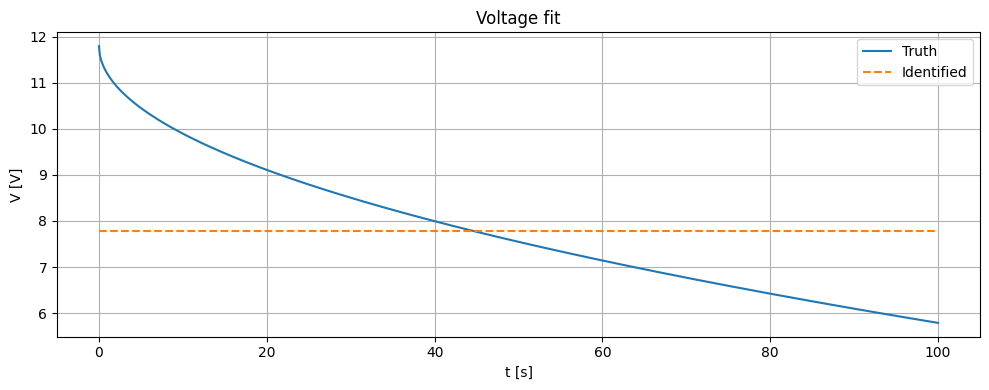

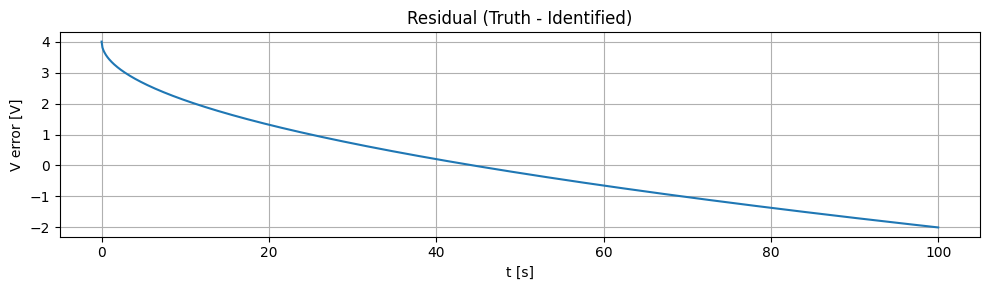

In [126]:
import numpy as np
import matplotlib.pyplot as plt

# --- use the time vector you trained on ---
tt = np.asarray(t).reshape(-1)

Y_np    = np.asarray(Y).reshape(-1)        # (N,)
Yhat_np = np.asarray(Yhat).reshape(-1)     # (N,)
e = Y_np - Yhat_np

plt.figure(figsize=(10,4))
plt.plot(tt, Y_np, label="Truth")
plt.plot(tt, Yhat_np, "--", label="Identified")
plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
plt.title("Voltage fit")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,3))
plt.plot(tt, e)
plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V error [V]")
plt.title("Residual (Truth - Identified)")
plt.tight_layout(); plt.show()


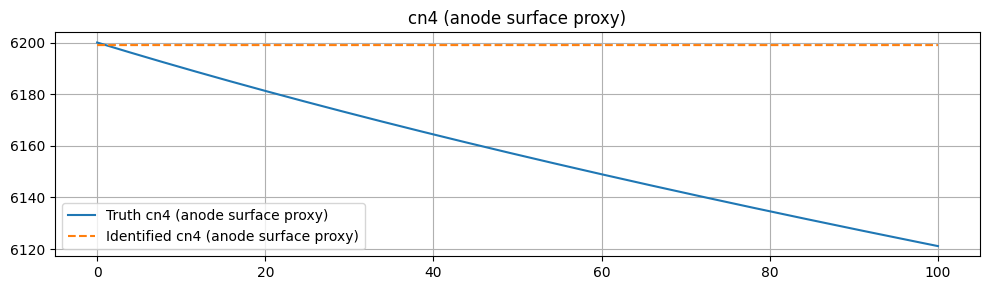

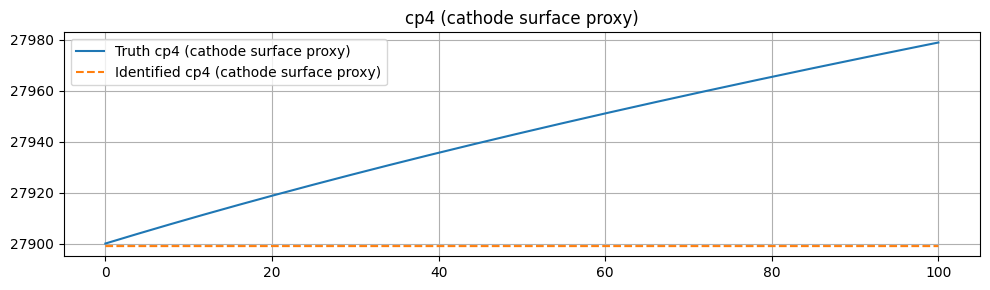

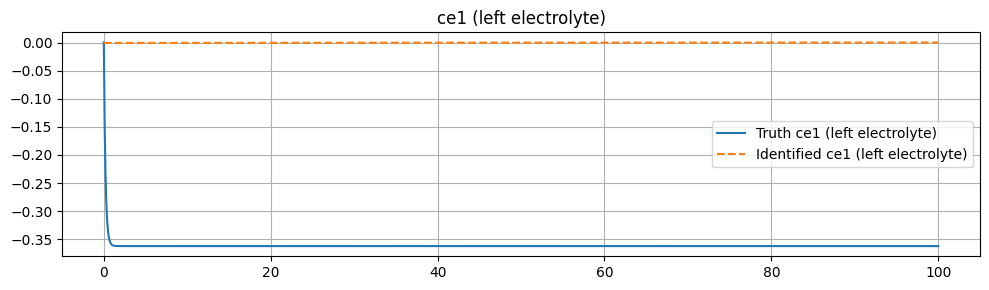

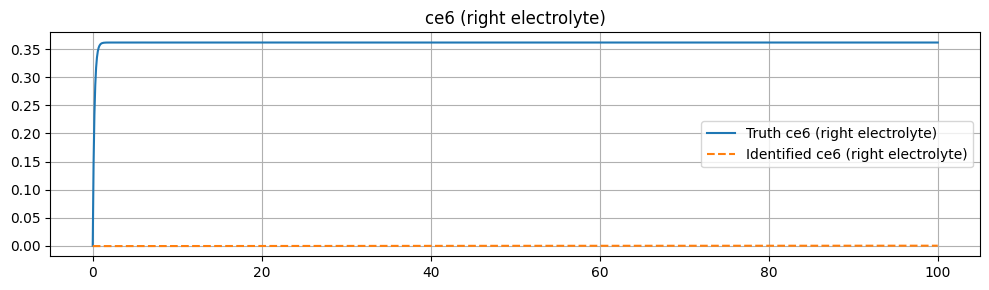

In [127]:
X_np    = np.asarray(X)                    # (N,14)
Xhat_np = np.asarray(Xhat)                 # (N,14)

def overlay_state(i, name):
    plt.figure(figsize=(10,3))
    plt.plot(tt, X_np[:, i], label=f"Truth {name}")
    plt.plot(tt, Xhat_np[:, i], "--", label=f"Identified {name}")
    plt.grid(True); plt.title(name); plt.legend(); plt.tight_layout(); plt.show()

overlay_state(3,  "cn4 (anode surface proxy)")
overlay_state(7,  "cp4 (cathode surface proxy)")
overlay_state(8,  "ce1 (left electrolyte)")
overlay_state(13, "ce6 (right electrolyte)")


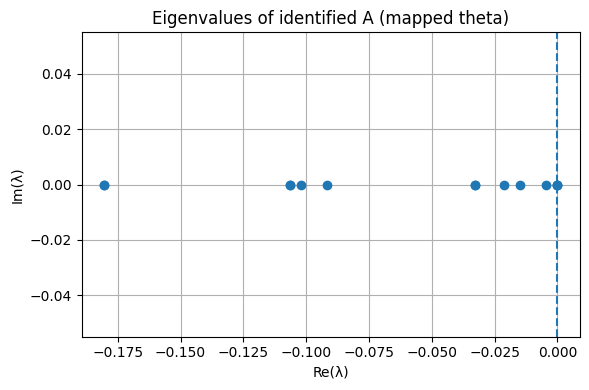

In [128]:
theta_raw = jnp.array(model.params[0])
theta = theta_map(theta_raw)
A_est, B_est = build_A_B_from_theta(theta)

eigA = np.linalg.eigvals(np.array(A_est))
plt.figure(figsize=(6,4))
plt.plot(np.real(eigA), np.imag(eigA), "o")
plt.axvline(0, linestyle="--")
plt.grid(True); plt.xlabel("Re(λ)"); plt.ylabel("Im(λ)")
plt.title("Eigenvalues of identified A (mapped theta)")
plt.tight_layout(); plt.show()


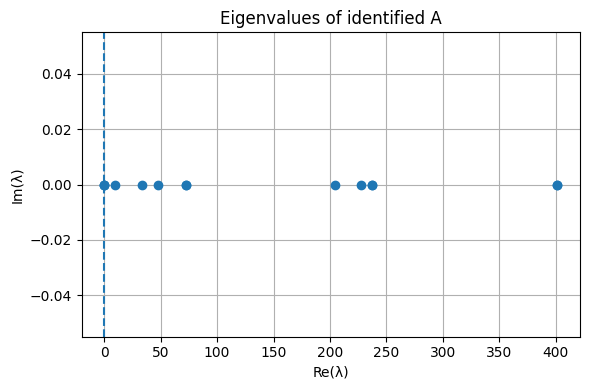

In [129]:
theta_est = model.params[0]           # if your params list is [theta]
A_est, B_est = build_A_B_from_theta(jnp.array(theta_est))

eigA = np.linalg.eigvals(np.array(A_est))
plt.figure(figsize=(6,4))
plt.plot(np.real(eigA), np.imag(eigA), "o")
plt.axvline(0, linestyle="--")
plt.grid(True); plt.xlabel("Re(λ)"); plt.ylabel("Im(λ)")
plt.title("Eigenvalues of identified A")
plt.tight_layout(); plt.show()


ValueError: x and y must have same first dimension, but have shapes (100001,) and (1001,)

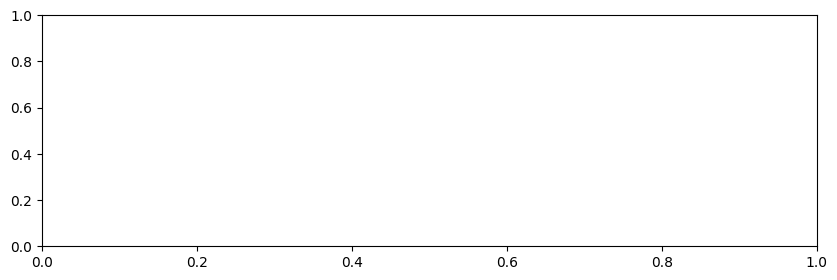

In [130]:
Xhat_np = np.array(Xhat)   # (N,14)

def overlay_state(i, name):
    plt.figure(figsize=(10,3))
    plt.plot(T, X[:, i], label=f"Truth {name}")
    plt.plot(T, Xhat_np[:, i], "--", label=f"Identified {name}")
    plt.grid(True); plt.title(name); plt.legend(); plt.tight_layout(); plt.show()

overlay_state(3,  "cn4 (anode surface proxy)")
overlay_state(7,  "cp4 (cathode surface proxy)")
overlay_state(8,  "ce1 (left electrolyte)")
overlay_state(13, "ce6 (right electrolyte)")


In [ ]:
# # -------------------------------
# # Stage 2 — Preprocess (scale) full dataset
# # -------------------------------
# Ys, ymean, ygain = standard_scale(Y)
# Us, umean, ugain = standard_scale(U)

# # sanity checks
# print("Y mean:", ymean.ravel(), "Y gain:", ygain.ravel())
# print("U mean:", umean.ravel(), "U gain:", ugain.ravel())


In [ ]:
# # # -------------------------------
# # # Stage 3A — Approach 1: Model (custom NN state/output maps)
# # # -------------------------------
# # # example_custom_nonlinear.py 
# # # example_dcgain.py

# # nx, nu, ny = 6, 1, 1
# # nnx, nny = 8, 8

# # def sigmoid(x):
# #     return 1.0 / (1.0 + jnp.exp(-x))

# # @jax.jit
# # def state_fcn(x, u, params):
# #     A, B, C, W1, W2, W3, b1, b2, W4, W5, b3, b4 = params
# #     return A@x + B@u + (W3 @ sigmoid(W1@x + W2@u + b1) + b2)

# # @jax.jit
# # def output_fcn(x, u, params):
# #     A, B, C, W1, W2, W3, b1, b2, W4, W5, b3, b4 = params
# #     return C@x + (W5 @ sigmoid(W4@x + b3) + b4)

# # def init_params(seed=0):
# #     rng = np.random.default_rng(seed)
# #     A = 0.8*np.eye(nx)
# #     B = 0.1*rng.standard_normal((nx, nu))
# #     C = 0.1*rng.standard_normal((ny, nx))
# #     W1 = 0.1*rng.standard_normal((nnx, nx))
# #     W2 = 0.5*rng.standard_normal((nnx, nu))
# #     W3 = 0.5*rng.standard_normal((nx, nnx))
# #     b1 = np.zeros(nnx)
# #     b2 = np.zeros(nx)
# #     W4 = 0.5*rng.standard_normal((nny, nx))
# #     W5 = 0.5*rng.standard_normal((ny, nny))
# #     b3 = np.zeros(nny)
# #     b4 = np.zeros(ny)
# #     return [A,B,C,W1,W2,W3,b1,b2,W4,W5,b3,b4]

# # m1 = Model(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)
# # m1.init(params=init_params(seed=0))

# # m1.loss(rho_x0=1e-4, rho_th=1e-4)
# # m1.optimization(adam_epochs=1000, lbfgs_epochs=2000)

# # t0 = time.time()
# # m1.fit(Ys, Us)   # <-- full dataset
# # m1_time = time.time() - t0

# # Ysh_1, _ = m1.predict(m1.x0, Us)
# # Yhat_1 = unscale(Ysh_1, ymean, ygain)

# # R2_1, _, msg1 = compute_scores(Y, Yhat_1, Y, Yhat_1, fit="R2")  # same arrays (fit-only)
# # print("Approach 1 time:", m1_time, "s")
# # print(msg1)


# # -------------------------------
# # Stage 3A — Improved Approach 1: dt-residual NN state-space
# # -------------------------------
# nx, nu, ny = 14, 1, 1
# nh = 32
# dt = float(t[1] - t[0])

# def act(x):
#     return jnp.tanh(x)

# # params layout (same for both):
# # [A, B, W1, W2, W3, b1, b2, C, W4, b3]

# @jax.jit
# def state_fcn(x, u, params):
#     A, B, W1, W2, W3, b1, b2, C, W4, b3 = params  # unpack ALL
#     h = act(W1 @ x + W2 @ u + b1)
#     f = (A @ x) + (B @ u) + (W3 @ h + b2)
#     return x + dt * f

# @jax.jit
# def output_fcn(x, u, params):
#     A, B, W1, W2, W3, b1, b2, C, W4, b3 = params
#     return (C @ x) + (W4 @ act(x) + b3)

# def init_params(seed=0):
#     rng = np.random.default_rng(seed)

#     A  = 0.0 * np.eye(nx)
#     B  = 0.01 * rng.standard_normal((nx, nu))

#     W1 = 0.05 * rng.standard_normal((nh, nx))
#     W2 = 0.05 * rng.standard_normal((nh, nu))
#     W3 = 0.05 * rng.standard_normal((nx, nh))
#     b1 = np.zeros(nh)
#     b2 = np.zeros(nx)

#     C  = 0.01 * rng.standard_normal((ny, nx))
#     W4 = 0.01 * rng.standard_normal((ny, nx))
#     b3 = np.zeros(ny)

#     return [A, B, W1, W2, W3, b1, b2, C, W4, b3]


# m1 = Model(nx, ny, nu, state_fcn=state_fcn, output_fcn=output_fcn)
# m1.init(params=init_params(seed=0))

# m1.loss(rho_x0=1e-3, rho_th=1e-4)              # a bit stronger on x0 helps
# m1.optimization(adam_epochs=200, lbfgs_epochs=0)  # start small, visualize early

# m1.fit(Ys, Us)


In [ ]:
# def quick_compare_plot(t, Y_true, Y_hat, title):
#     N = min(2000, len(t))  # first 2000 points (~200s at dt=0.1)
#     plt.figure(figsize=(12,4))
#     plt.plot(t[:N], Y_true[:N], label="Truth")
#     plt.plot(t[:N], Y_hat[:N], label="Model")
#     plt.grid(True)
#     plt.xlabel("t [s]"); plt.ylabel("V [V]")
#     plt.title(title)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# checkpoints = [20, 50, 200, 500, 1000]
# for k in checkpoints:
#     m1.optimization(adam_epochs=k, lbfgs_epochs=0)
#     m1.fit(Ys, Us)   # should continue from current params in most setups

#     Ysh, _ = m1.predict(m1.x0, Us)
#     Yhat = unscale(Ysh, ymean, ygain)

#     quick_compare_plot(t, Y, Yhat, f"Approach 1 (dt-residual) after {k} ADAM epochs")


In [ ]:
# m1.optimization(adam_epochs=0, lbfgs_epochs=2000)
# m1.fit(Ys, Us)

# Ysh_1, _ = m1.predict(m1.x0, Us)
# Yhat_1 = unscale(Ysh_1, ymean, ygain)


In [ ]:
# # -------------------------------
# # Stage 3B — Approach 2: RNN (flax)
# # -------------------------------
# # example_rnn.py
# import flax.linen as nn

# nx_rnn = 8

# class FX(nn.Module):
#     @nn.compact
#     def __call__(self, xu):
#         x = nn.Dense(32)(xu)
#         x = nn.tanh(x)
#         x = nn.Dense(nx_rnn)(x)
#         return x

# class FY(nn.Module):
#     @nn.compact
#     def __call__(self, x):
#         y = nn.Dense(32)(x)
#         y = nn.tanh(y)
#         y = nn.Dense(1)(y)
#         return y

# m2 = RNN(nx=nx_rnn, ny=1, nu=1, FX=FX, FY=FY, x_scaling=0.1)
# m2.loss(rho_x0=1e-4, rho_th=0.0, tau_th=1e-4)
# m2.optimization(adam_epochs=0, lbfgs_epochs=2000)

# t0 = time.time()
# m2.fit(Ys, Us)   # <-- full dataset
# m2_time = time.time() - t0

# Ysh_2, _ = m2.predict(m2.x0, Us)
# Yhat_2 = unscale(Ysh_2, ymean, ygain)

# R2_2, _, msg2 = compute_scores(Y, Yhat_2, Y, Yhat_2, fit="R2")
# print("Approach 2 time:", m2_time, "s")
# print(msg2)


In [ ]:
# # -------------------------------
# # Stage 3C — Approach 3: CTModel (continuous-time surrogate)
# # -------------------------------
# # example_continuous_time_linear
# # example_continuous_time_mimo
# nx_ct, nu, ny = 6, 1, 1

# def act(x):
#     return x / (1.0 + jnp.exp(-x))

# @jax.jit
# def ct_state_fcn(x, u, t, params):
#     A, B, W1, W2, W3, b1, b2, C = params
#     return A@x + B@u + W3 @ act(W1@x + W2@u + b1) + b2

# @jax.jit
# def ct_output_fcn(x, u, t, params):
#     C = params[-1]
#     return C@x

# def ct_init(seed=0):
#     rng = np.random.default_rng(seed)
#     A = -np.eye(nx_ct)
#     B = 0.1*rng.standard_normal((nx_ct, nu))
#     W1 = 0.1*rng.standard_normal((16, nx_ct))
#     W2 = 0.5*rng.standard_normal((16, nu))
#     W3 = 0.5*rng.standard_normal((nx_ct, 16))
#     b1 = np.zeros(16)
#     b2 = np.zeros(nx_ct)
#     C  = 0.1*rng.standard_normal((ny, nx_ct))
#     return [A,B,W1,W2,W3,b1,b2,C]

# m3 = CTModel(nx_ct, ny, nu, state_fcn=ct_state_fcn, output_fcn=ct_output_fcn)
# m3.integration_options(ode_solver=diffrax.Heun(), dt0=float(t[1] - t[0]))  # match your sim_dt
# m3.init(params=ct_init(seed=0))
# m3.loss(rho_x0=1e-4, rho_th=1e-4, train_x0=True)
# m3.optimization(adam_epochs=500, lbfgs_epochs=2000)

# t0 = time.time()
# m3.fit(Ys, Us, t)   # <-- full dataset + time grid
# m3_time = time.time() - t0

# x0_3 = m3.learn_x0(Us, Ys, t)
# Ysh_3, _ = m3.predict(x0_3, Us, t)
# Yhat_3 = unscale(Ysh_3, ymean, ygain)

# R2_3, _, msg3 = compute_scores(Y, Yhat_3, Y, Yhat_3, fit="R2")
# print("Approach 3 time:", m3_time, "s")
# print(msg3)


In [ ]:
# # -------------------------------
# # Stage 4 — Compare fits (training-only)
# # -------------------------------
# plt.figure(figsize=(12,4))
# plt.plot(t, Y, label="Truth")
# plt.plot(t, Yhat_1, label="1) Model")
# plt.plot(t, Yhat_2, label="2) RNN")
# # plt.plot(t, Yhat_3, label="3) CTModel")
# plt.grid(True); plt.xlabel("t [s]"); plt.ylabel("V [V]")
# plt.title("Training-only fit on a single discharge cycle")
# plt.legend(); plt.tight_layout(); plt.show()

# import pandas as pd
# summary = pd.DataFrame([
#     {"approach":"1) Model (custom)", "R2_fit": float(R2_1), "time_s": m1_time},
#     {"approach":"2) RNN (flax)",     "R2_fit": float(R2_2), "time_s": m2_time},
#     # {"approach":"3) CTModel",        "R2_fit": float(R2_3), "time_s": m3_time},
# ])
# summary
